In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

(<matplotlib.image.AxesImage at 0x12015bb90>, Text(0.5, 1.0, 'Raod 2'))

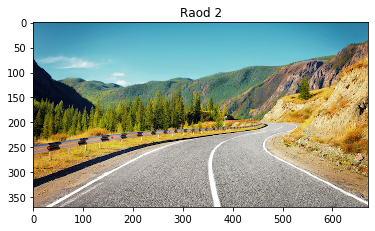

In [2]:
# โหลดภาพต้นฉบับ
img = cv2.imread('./road2.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Raod 2')

In [3]:
img.shape

(370, 672, 3)

In [4]:
# ตัดภาพมาเพื่อทำเป็น Model ตัดเฉพาะ object ที่ต้องการจะ Detect
img_copy = img.copy()
model_bgr = img_copy[275:, 200:500]
plt.imshow(cv2.cvtColor(model, cv2.COLOR_BGR2RGB)), plt.title('Crop Raod 2')

NameError: name 'model' is not defined

In [5]:
# Convert bgr to hsv ทั้งภาพหลัก และภาพที่ Crop
src_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
model_hsv = cv2.cvtColor(model_bgr, cv2.COLOR_BGR2HSV)

size = 46080 
shape = (180, 256) 
dtype = float32 
min = 0.0 
max = 1846.0 
value total = 28500.0
[[736.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


<function matplotlib.pyplot.show(*args, **kw)>

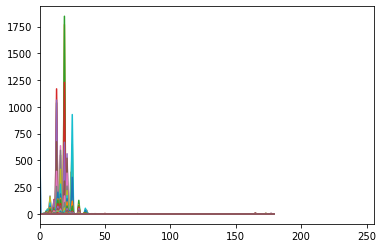

In [6]:
# สร้าง histogram ที่ตอนนี้มี 2 dimension คือ h กับ s
model_hist_hs = cv2.calcHist([model_hsv], [0,1], None, [180,256],[0,180,0,256])
                          # image, channels ที่จะทำ (h,s), mask, bins, range

print('size =', model_hist_hs.size, '\nshape =', model_hist_hs.shape, '\ndtype =', model_hist_hs.dtype,
     '\nmin =', model_hist_hs.min(), '\nmax =', model_hist_hs.max(), '\nvalue total =', model_hist_hs.sum())
print(model_hist_hs)

plt.plot(model_hist_hs)
plt.xlim([0,256])
plt.show

size = 46080 
shape = (180, 256) 
dtype = float32 
min = 0.0 
max = 254.99998 
value total = 3936.8906
[[101.66847   0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 ...
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]]


<function matplotlib.pyplot.show(*args, **kw)>

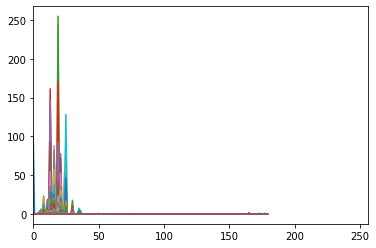

In [7]:
# เอา Histogram ที่ได้มา Normalize ก่อนให้อยู่ในช่วง [0-255] ตอนแรกมันเป็นความถี่ที่สูงมาก
model_hist_hs_norm = model_hist_hs.copy()
model_hist_hs_norm = cv2.normalize(model_hist_hs, model_hist_hs_norm, 0, 255, cv2.NORM_MINMAX)
                                    #image_source, image_destination, min, max, normalize
    
print('size =', model_hist_hs_norm.size, '\nshape =',model_hist_hs_norm.shape, '\ndtype =',model_hist_hs_norm.dtype,
     '\nmin =', model_hist_hs_norm.min(), '\nmax =', model_hist_hs_norm.max(), '\nvalue total =', model_hist_hs_norm.sum())
print(model_hist_hs_norm)

plt.plot(model_hist_hs_norm)
plt.xlim([0,256])
plt.show

สังเกตุว่าแกนจากเป็นพัน เหลือแค่ 255 แล้ว เพราะ Normalize

248640 (370, 672) uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


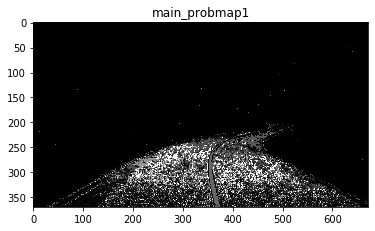

In [8]:
# ทำ Back Projection
main_probmap1 = cv2.calcBackProject([src_hsv], [0,1], model_hist_hs_norm, [0,180,0,256], 1)
                                    # main image hsv, channel, histogram  , range , scale factor

    
print( main_probmap1.size, main_probmap1.shape, main_probmap1.dtype )
print( main_probmap1 )
plt.title('main_probmap1')
plt.imshow( main_probmap1, cmap='gray' )


kernel = (5, 5) uint8 :
[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]
248640 (370, 672) uint8
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 15 17 18]
 [ 0  0  0 ...  2  4 12]
 [ 0  0  0 ...  1  1  2]]


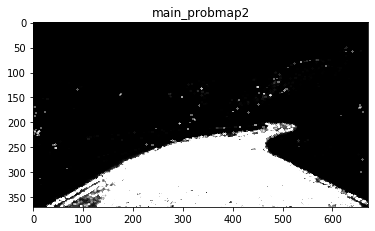

In [9]:
# ใช้ kernel วงกลมเพื่อปรับภาพให้สว่างมากขึ้น
# Convolute with a circular kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
main_probmap2 = cv2.filter2D( main_probmap1, -1, kernel )

print( 'kernel =', kernel.shape, kernel.dtype, ':' )
print( kernel )

print( main_probmap2.size, main_probmap2.shape, main_probmap2.dtype )
print( main_probmap2 )
plt.title('main_probmap2')
plt.imshow( main_probmap2, cmap='gray' )

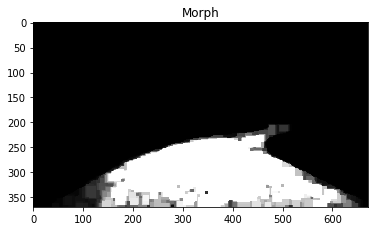

In [10]:
# ปรับปรุงเพิ่มเติมด้วย Morphological Operation
# morphology
ksize = 5
cnt_dilate = 3
cnt_erode = 4
kernel = cv2.getStructuringElement( cv2.MORPH_RECT, (ksize,ksize) )

main_probmap3 = cv2.erode ( main_probmap2, kernel, iterations=cnt_erode )
main_probmap3 = cv2.dilate ( main_probmap3, kernel, iterations=cnt_dilate )


plt.title( 'Morph' ) 
plt.imshow( main_probmap3, cmap='gray' )

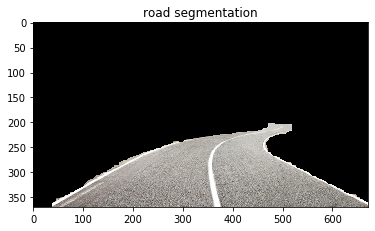

In [13]:
# แสดงผลของการ Segment ลงบนภาพจริง
result = img.copy()
result [ main_probmap3 == 0 ] = 0
# result = cv2.bitwise_and(img, cv2.cvtColor(main_probmap3, cv2.COLOR_GRAY2BGR))

plt.title( 'road segmentation' ) 
plt.imshow( cv2.cvtColor( result, cv2.COLOR_BGR2RGB ) )

# Road 1

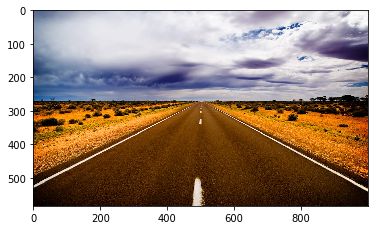

In [47]:
# Load image
src_bgr = cv2.imread('./road1.jpg')
plt.imshow(cv2.cvtColor(src_bgr, cv2.COLOR_BGR2RGB))

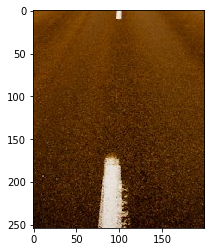

In [48]:
# Create model
model_bgr = src_bgr.copy()
model_bgr =  model_bgr[330:,400:600]
plt.imshow(cv2.cvtColor(model_bgr, cv2.COLOR_BGR2RGB))

In [49]:
# Convert model bgr to to hsv
src_hsv = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2HSV)
model_hsv = cv2.cvtColor(model_bgr, cv2.COLOR_BGR2HSV)

In [64]:
# Compute histogram H V of model

# *** ลองเปลี่ยน Channels จาก 0 กับ 1 เป็น 0 กับ 2 เพราะคำตอบดีกว่า แต่ขี้เกียจเปลี่ยนตัวแปร hs จ้า
model_hist_hs = cv2.calcHist([model_hsv], [0,2], None, [180,256], [0,180,0,256]) # image, channel, mask, bin, range
print('size =', model_hist_hs.size, '\nshape =', model_hist_hs.shape, '\ndtype =', model_hist_hs.dtype,
     '\nmin =', model_hist_hs.min(), '\nmax =', model_hist_hs.max(), '\nvalue total =', model_hist_hs.sum())
print(model_hist_hs)

size = 46080 
shape = (180, 256) 
dtype = float32 
min = 0.0 
max = 565.0 
value total = 50800.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [65]:
# Normalize value to 0-255  (from 0-785)
model_hist_hs_norm = model_hist_hs.copy()
model_hist_hs_norm = cv2.normalize( model_hist_hs, model_hist_hs_norm, 0, 255, cv2.NORM_MINMAX)  
    #image_source, image_destination, min, max, normalize

    
print('size =', model_hist_hs_norm.size, '\nshape =',model_hist_hs_norm.shape, '\ndtype =',model_hist_hs_norm.dtype,
     '\nmin =', model_hist_hs_norm.min(), '\nmax =', model_hist_hs_norm.max(), '\nvalue total =', model_hist_hs_norm.sum())
print(model_hist_hs_norm)

size = 46080 
shape = (180, 256) 
dtype = float32 
min = 0.0 
max = 255.0 
value total = 22927.434
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


584000 (584, 1000) uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


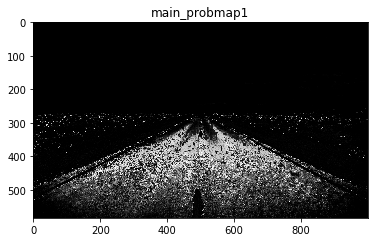

In [67]:
# Apply backprojection
main_probmap1 = cv2.calcBackProject( [src_hsv], [0,2], model_hist_hs_norm, [0,180,0,256], 1 )      
    # main image hsv, channel, histogram  , range , scale factor

print( main_probmap1.size, main_probmap1.shape, main_probmap1.dtype )
print( main_probmap1 )
plt.title('main_probmap1')
plt.imshow( main_probmap1, cmap='gray' )

kernel = (3, 3) uint8 :
[[0 1 0]
 [1 1 1]
 [0 1 0]]
584000 (584, 1000) uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


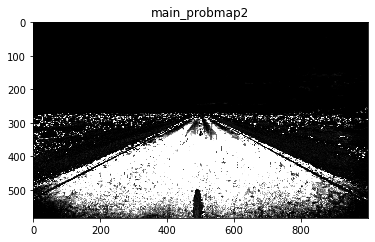

In [68]:
# Convolute with a circular kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
main_probmap2 = cv2.filter2D( main_probmap1, -1, kernel )

print( 'kernel =', kernel.shape, kernel.dtype, ':' )
print( kernel )

print( main_probmap2.size, main_probmap2.shape, main_probmap2.dtype )
print( main_probmap2 )
plt.title('main_probmap2')
plt.imshow( main_probmap2, cmap='gray' )

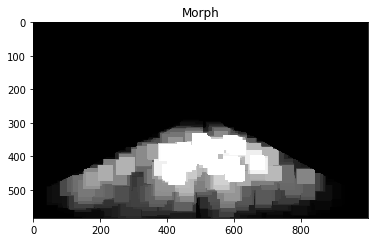

In [69]:
# morphology
ksize = 7
cnt_dilate = 7
cnt_erode = 4
kernel = cv2.getStructuringElement( cv2.MORPH_RECT, (ksize,ksize) )

main_probmap3 = cv2.erode ( main_probmap2, kernel, iterations=cnt_erode )
main_probmap3 = cv2.dilate ( main_probmap3, kernel, iterations=cnt_dilate )


plt.title( 'Morph' ) 
plt.imshow( main_probmap3, cmap='gray' )

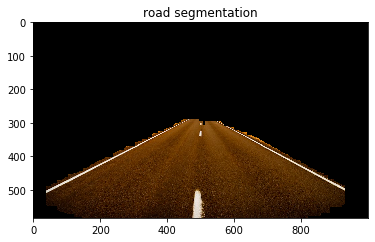

In [70]:
result = src_bgr.copy()
result [ main_probmap3 == 0 ] = 0

plt.title( 'road segmentation' ) 
plt.imshow( cv2.cvtColor( result, cv2.COLOR_BGR2RGB ) )

# Histogram on video

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

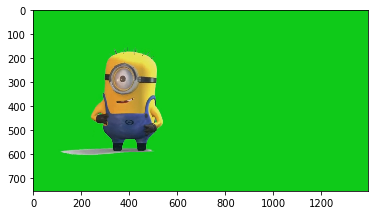

In [2]:
img = cv2.imread('./Minion-Image.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

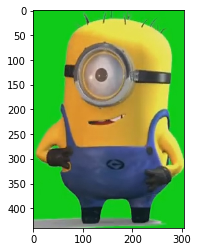

In [3]:
# create model (crop)
model_bgr = img.copy()
model_bgr = model_bgr[155:595,235:540]
plt.imshow(cv2.cvtColor(model_bgr, cv2.COLOR_BGR2RGB))

In [4]:
# import video file
video = cv2.VideoCapture('./Minion.mp4')

if video.isOpened():
    print('Video file is opened successfully')
else:
    print('Error')

Video file is opened successfully


In [ ]:
while True:
    retval, img = video.read(20)
    if (retval):
        # Create model
        model_bgr = img.copy()
        model_bgr = model_bgr[155:595,235:540]
        
        #Convert bgr to hsv
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        model_hsv = cv2.cvtColor(model_bgr, cv2.COLOR_BGR2HSV)
        
        # Compute histogram from h,s model
        model_hist_hs = cv2.calcHist([model_hsv], [0,1], None, [180,256], [0,180,0,256])
                                        # image, channel, mask, bin, range
        
        # Normalize hist model to 0-255 value
        model_hist_hs_norm = model_hist_hs.copy()
        model_hist_hs_norm = cv2.normalize( model_hist_hs, model_hist_hs_norm, 0, 255, cv2.NORM_MINMAX)
                                        #image_source, image_destination, min, max, normalize
        
        # Black projection
        main_probmap1 = cv2.calcBackProject([img_hsv], [0,1], model_hist_hs_norm, [0,180,0,256], 1)
                                        # main image hsv, channel, histogram  , range , scale factor
        
        # ปรับให้สว่างขึ้นด้วย kernel วงกลม
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        main_probmap2 = cv2.filter2D(main_probmap1, -1, kernel)
        
        # Morphological
        ksize = 3
        dilate = 3
        erode = 2
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
        
        morph_result = cv2.dilate(main_probmap2, kernel, iterations = dilate)
        morph_result = cv2.erode(morph_result, kernel, iterations = erode)
        
        # แสดงผล
        result = img.copy()
        result[morph_result == 255] = 0
        # ไม่รู้ทำไมรูปมินเนี่ยนมันเป็นสีดำ แล้วพื้นหลังดันเป็นสีขาว เลยต้องกำหนดให้
        # พื้นที่ที่เป็นสีขาว มันเท่ากับ 0 แทน
#         result_2 = cv2.bitwise_xor(img, cv2.cvtColor(morph_result, cv2.COLOR_GRAY2BGR))
        # พอใช้ xor แล้วพื้นหลังสีเพี้ยน
        
        cv2.imshow('Video', result)
    else:
        print('Error')
        
    if (cv2.waitKey(100)==27):
        break
        
cv2.destroyAllWindows()
if video.isOpened():
    video.release()

In [ ]:
cv2.destroyAllWindows()
if video.isOpened():
    video.release()